## Install Dependencies

In [1]:
%pip install matplotlib

import numpy as np
from matplotlib import pyplot as plt
from statistics import mean


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
def printb(text: str) -> None:
    print("\033[1m" + text + "\033[0m")

## Load result data

In [3]:
import json 

with open("experiment_results.json", "r") as results_file:
    experiments = json.load(results_file)

In [4]:
available_tags = set([
    experiment["params"]["tag"] for experiment in experiments
])
print("available tags:", available_tags)

available tags: {'varying_qubits', 'reordering_varying_steps', 'reordering_varying_redundancy', 'varying_gates', 'varying_redundancy'}


## RQ1: How does the degree of redundancy within a population influence the behavior of the proposed simulation approach?

In [5]:
# Filter out and format experiment results with the varying_redundancy tag

vr_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "varying_redundancy"]
print(f"Total amount of varying_redundancy experiments: {len(vr_experiments)}")

Total amount of varying_redundancy experiments: 80


In [6]:
redundancies = [experiment["params"]["redundancy"] for experiment in vr_experiments]
redundancies = list(set(redundancies))
redundancies.sort()

print("Redundancies:", redundancies)

Redundancies: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


Total simulation time, averaged across seeds:


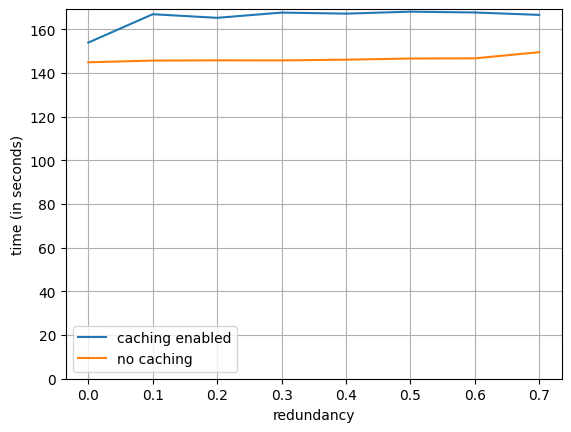

In [7]:
# Create a line chart with simulation time on y and redundancy level
# on x. One line for the runs with caching enabled, one line for the
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for redundancy in redundancies:

    sel_durations_no_cache = [
        experiment["total_duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["total_duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))


ax = plt.subplot()
ax.plot(redundancies, durations_with_cache)
ax.plot(redundancies, durations_no_cache)
ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Total simulation time, averaged across seeds:")

plt.legend(["caching enabled", "no caching"])
plt.grid()
plt.show()

Net simulation time, averaged across seeds:


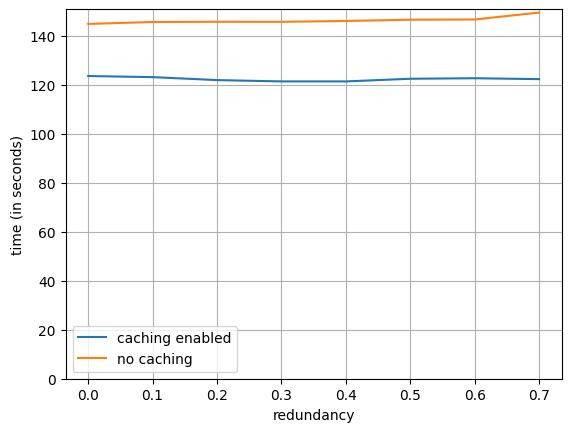

In [8]:
# Create a line chart with net simulation time on y and redundancy level
# on x. One line for the runs with caching enabled, one line for the
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for redundancy in redundancies:

    sel_durations_no_cache = [
        experiment["simulate_without_cache"]["duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["simulate_using_cache"]["duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))


ax = plt.subplot()
ax.plot(redundancies, durations_with_cache)
ax.plot(redundancies, durations_no_cache)
ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Net simulation time, averaged across seeds:")

plt.legend(["caching enabled", "no caching"])
plt.grid()
plt.show()

In [9]:
# plot simulation time of each seed

seeds = [experiment["params"]["seed"] for experiment in vr_experiments]
seeds = list(set(seeds))

print(seeds)

[0, 1, 2, 3, 4]


Total simulation time with caching disabled:


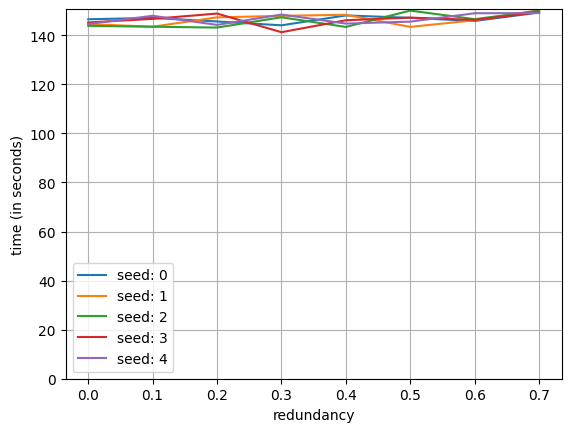

In [10]:
# plot simulation time of each seed without cache

ax = plt.subplot()

for seed in seeds:
    seed_durations_no_cache = []

    for redundancy in redundancies:

        sel_durations_no_cache = [
            experiment["total_duration"]
            for experiment in vr_experiments
            if experiment["params"]["cache_size"] == 0
            and experiment["params"]["seed"] == seed
            and experiment["params"]["redundancy"] == redundancy
        ]

        assert len(sel_durations_no_cache) == 1, "Too many results for one seed value!"

        seed_durations_no_cache.append(sel_durations_no_cache[0])

    ax.plot(redundancies, seed_durations_no_cache)

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)


printb("Total simulation time with caching disabled:")
plt.legend([f"seed: {seed}" for seed in seeds])
plt.grid()
plt.show()

Total simulation time with caching enabled:


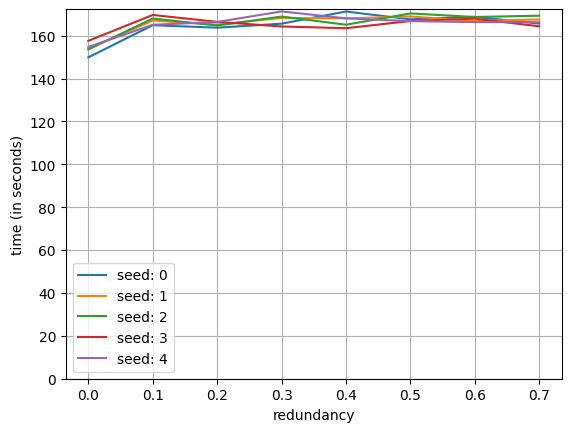

In [11]:
# plot simulation time of each seed with cache

ax = plt.subplot()

for seed in seeds:
    seed_durations_with_cache = []

    for redundancy in redundancies:

        sel_durations_with_cache = [
            experiment["total_duration"]
            for experiment in vr_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["seed"] == seed
            and experiment["params"]["redundancy"] == redundancy
        ]

        assert len(sel_durations_no_cache) == 1, "Too many results for one seed value!"

        seed_durations_with_cache.append(sel_durations_with_cache[0])

    ax.plot(redundancies, seed_durations_with_cache)

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Total simulation time with caching enabled:")
plt.legend([f"seed: {seed}" for seed in seeds])
plt.grid()
plt.show()

Cache buildup and net simulation time, averaged across seeds:


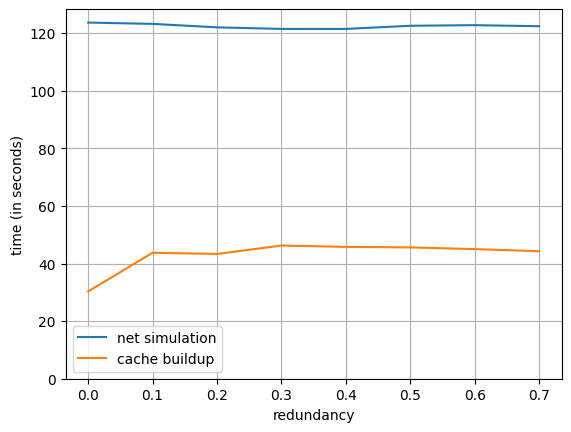

In [12]:
# Create a line chart with simulation vs. preparation time of 
# caching enabled.
simulation_durations = []
overhead_durations = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    sel_simulation_durations = [
        experiment["simulate_using_cache"]["duration"]
        for experiment in relevant_experiments
    ]
    sel_overhead_durations = [
        experiment["total_duration"] - experiment["simulate_using_cache"]["duration"]
        for experiment in relevant_experiments
    ]

    simulation_durations.append(mean(sel_simulation_durations))
    overhead_durations.append(mean(sel_overhead_durations))


ax = plt.subplot()
ax.plot(redundancies, simulation_durations)
ax.plot(redundancies, overhead_durations)
ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Cache buildup and net simulation time, averaged across seeds:")
plt.legend(["net simulation", "cache buildup"])
plt.grid()
plt.show()

Net simulation time with caching enabled:


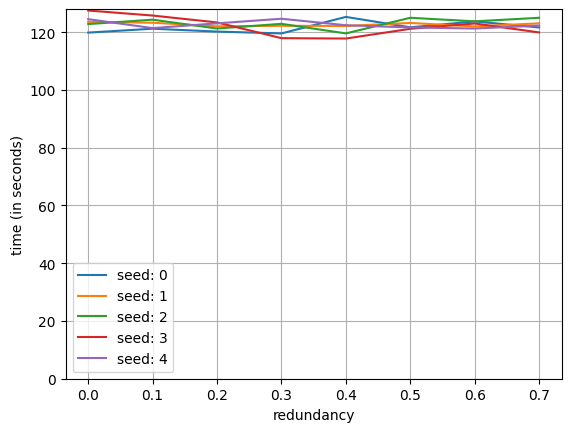

In [13]:
# Create a line chart with simulation time per seed

ax = plt.subplot()

for seed in seeds:
    seed_simulation_durations = []

    for redundancy in redundancies:
        relevant_experiments = [
            experiment
            for experiment in vr_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["seed"] == seed
            and experiment["params"]["redundancy"] == redundancy
        ]

        sel_simulation_durations = [
            experiment["simulate_using_cache"]["duration"]
            for experiment in relevant_experiments
        ]

        assert len(sel_simulation_durations) == 1, "Too many results per seed"

        seed_simulation_durations.append(sel_simulation_durations[0])

    ax.plot(redundancies, seed_simulation_durations)

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Net simulation time with caching enabled:")
plt.legend([f"seed: {seed}" for seed in seeds])
plt.grid()
plt.show()

Cache buildup time when caching enabled:


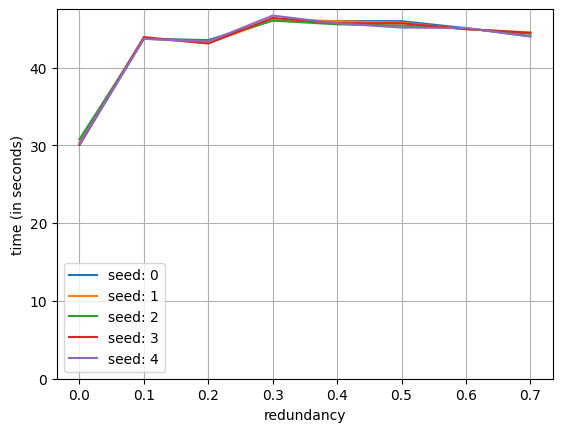

In [14]:
# Create a line chart with cache build time per seed

ax = plt.subplot()

for seed in seeds:
    seed_overhead_durations = []

    for redundancy in redundancies:
        relevant_experiments = [
            experiment
            for experiment in vr_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["seed"] == seed
            and experiment["params"]["redundancy"] == redundancy
        ]

        sel_overhead_durations = [
            experiment["total_duration"]
            - experiment["simulate_using_cache"]["duration"]
            for experiment in relevant_experiments
        ]

        assert len(sel_overhead_durations) == 1, "Too many results per seed"

        seed_overhead_durations.append(sel_overhead_durations[0])

    ax.plot(redundancies, seed_overhead_durations)

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Cache buildup time when caching enabled:")
plt.legend([f"seed: {seed}" for seed in seeds])
plt.grid()
plt.show()

Time distribution when caching is enabled:


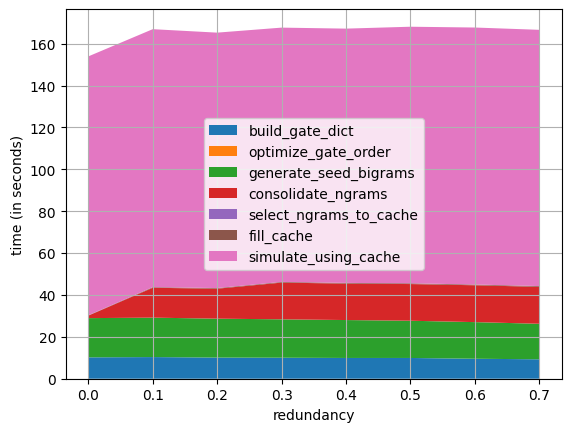

In [15]:
# Create a stack chart of the durations of different algorithm steps
# for all runs where cache size = 100.

build_gate_dict_durations = []
optimize_gate_order_durations = []
generate_seed_bigrams_durations = []
consolidate_ngrams_durations = []
select_ngrams_to_cache_durations = []
fill_cache_durations = []
simulate_using_cache_durations = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    build_gate_dict_durations.append(
        mean(
            [
                experiment["build_gate_frequency_dict"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    optimize_gate_order_durations.append(
        mean(
            [
                experiment["optimize_gate_order"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    generate_seed_bigrams_durations.append(
        mean(
            [
                experiment["generate_seed_bigrams"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    consolidate_ngrams_durations.append(
        mean(
            [
                experiment["consolidate_ngrams"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    select_ngrams_to_cache_durations.append(
        mean(
            [
                experiment["select_ngrams_to_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    fill_cache_durations.append(
        mean(
            [
                experiment["fill_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    simulate_using_cache_durations.append(
        mean(
            [
                experiment["simulate_using_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )

x = redundancies
y = np.vstack(
    [
        build_gate_dict_durations,
        optimize_gate_order_durations,
        generate_seed_bigrams_durations,
        consolidate_ngrams_durations,
        select_ngrams_to_cache_durations,
        fill_cache_durations,
        simulate_using_cache_durations,
    ],
)

fig, ax = plt.subplots()

ax.stackplot(x, y)
ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")

plt.legend(
    [
        "build_gate_dict",
        "optimize_gate_order",
        "generate_seed_bigrams",
        "consolidate_ngrams",
        "select_ngrams_to_cache",
        "fill_cache",
        "simulate_using_cache",
    ]
)
plt.grid()

printb("Time distribution when caching is enabled:")
plt.show()

Distribution of the length of ngrams added to the cache:


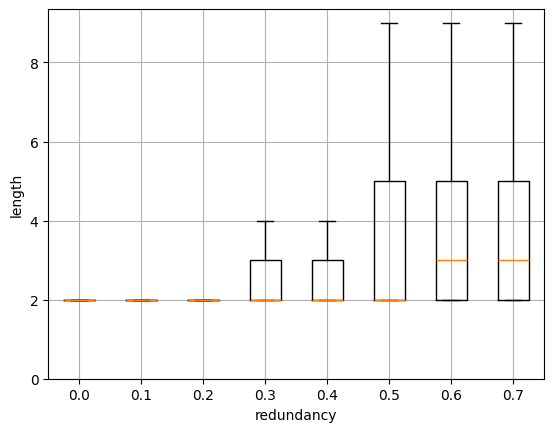

In [16]:
# Create box plots for sequence lengths of cached ngrams
# at different redundancy levels.

sequence_lengths = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment for experiment in vr_experiments if 
        experiment["params"]["cache_size"] > 0 and experiment["params"]["redundancy"] == redundancy
    ]

    relevant_sequence_lengths = []
    for experiment in relevant_experiments:
        relevant_sequence_lengths.extend(experiment["fill_cache"]["ngram_lengths"])


    sequence_lengths.append(relevant_sequence_lengths)

fig, ax = plt.subplots()

ax.boxplot(sequence_lengths, showfliers=False)
ax.set_xlabel("redundancy")
ax.set_ylabel("length")
ax.set_ylim(0)

plt.xticks([i + 1 for i in range(len(redundancies))], redundancies)

printb("Distribution of the length of ngrams added to the cache:")

plt.grid()
plt.show()



Distribution of the frequency of each cached ngram in the population:


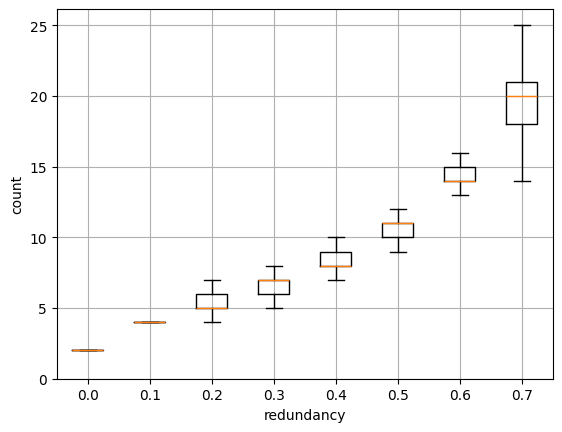

In [17]:
# Create box plots for frequency of cached ngrams at different redundancy levels.

frequencies = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment for experiment in vr_experiments if 
        experiment["params"]["cache_size"] > 0 and experiment["params"]["redundancy"] == redundancy
    ]

    relevant_frequencies = []
    for experiment in relevant_experiments:
        relevant_frequencies.extend(experiment["fill_cache"]["ngram_frequencies"])


    frequencies.append(relevant_frequencies)

fig, ax = plt.subplots()

ax.boxplot(frequencies, showfliers=False)
ax.set_xlabel("redundancy")
ax.set_ylabel("count")
ax.set_ylim(0)

plt.xticks([i + 1 for i in range(len(redundancies))], redundancies)

printb("Distribution of the frequency of each cached ngram in the population:")

plt.grid()
plt.show()

## RQ2.1: How does the amount of qubits in the population influence simulation speed?

In [18]:
# Filter out and format experiment results with the varying_qubits tag

vq_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "varying_qubits"]
print(f"Total amount of varying_qubits experiments: {len(vq_experiments)}")

Total amount of varying_qubits experiments: 60


In [19]:
qubit_nums = [experiment["params"]["qubit_num"] for experiment in vq_experiments]
qubit_nums = list(set(qubit_nums))
qubit_nums.sort()

print("Qubit counts:", qubit_nums)

Qubit counts: [3, 4, 5, 6, 7, 8]


Total simulation time, averaged across seeds:


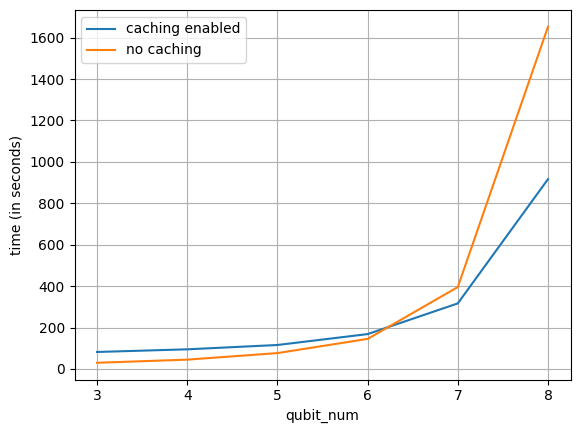

In [20]:
# Create a line chart with simulation time on y and qubit count 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for qubit_num in qubit_nums:

    sel_durations_no_cache = [
        experiment["total_duration"]
        for experiment in vq_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["qubit_num"] == qubit_num
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["total_duration"]
        for experiment in vq_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["qubit_num"] == qubit_num
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))

ax = plt.subplot()
ax.plot(qubit_nums, durations_with_cache)
ax.plot(qubit_nums, durations_no_cache)
ax.set_xlabel("qubit_num")
ax.set_ylabel("time (in seconds)")

printb("Total simulation time, averaged across seeds:")
plt.legend(["caching enabled", "no caching"])
plt.grid()
plt.show()


Components of total simulation time, averaged across seeds:


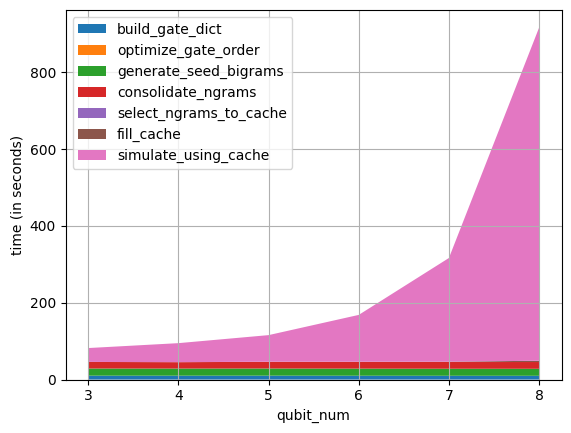

In [21]:
# Create a stack chart of the durations of different algorithm steps
# for all runs where cache size = 100.

build_gate_dict_durations = []
optimize_gate_order_durations = []
generate_seed_bigrams_durations = []
consolidate_ngrams_durations = []
select_ngrams_to_cache_durations = []
fill_cache_durations = []
simulate_using_cache_durations = []

for qubit_num in qubit_nums:

    relevant_experiments = [
        experiment
        for experiment in vq_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["qubit_num"] == qubit_num
    ]

    build_gate_dict_durations.append(
        mean(
            [
                experiment["build_gate_frequency_dict"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    optimize_gate_order_durations.append(
        mean(
            [
                experiment["optimize_gate_order"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    generate_seed_bigrams_durations.append(
        mean(
            [
                experiment["generate_seed_bigrams"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    consolidate_ngrams_durations.append(
        mean(
            [
                experiment["consolidate_ngrams"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    select_ngrams_to_cache_durations.append(
        mean(
            [
                experiment["select_ngrams_to_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    fill_cache_durations.append(
        mean(
            [
                experiment["fill_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    simulate_using_cache_durations.append(
        mean(
            [
                experiment["simulate_using_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )

x = qubit_nums
y = np.vstack(
    [
        build_gate_dict_durations,
        optimize_gate_order_durations,
        generate_seed_bigrams_durations,
        consolidate_ngrams_durations,
        select_ngrams_to_cache_durations,
        fill_cache_durations,
        simulate_using_cache_durations,
    ],
)

fig, ax = plt.subplots()

ax.stackplot(x, y)
ax.set_xlabel("qubit_num")
ax.set_ylabel("time (in seconds)")

printb("Components of total simulation time, averaged across seeds:")

plt.legend(
    [
        "build_gate_dict",
        "optimize_gate_order",
        "generate_seed_bigrams",
        "consolidate_ngrams",
        "select_ngrams_to_cache",
        "fill_cache",
        "simulate_using_cache",
    ]
)
plt.grid()

plt.show()

## RQ2.2: How does the amount of gates per circuit influence simulation speed?

In [22]:
# Filter out and format experiment results with the varying_gates tag

vg_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "varying_gates"]
print(f"Total amount of varying_gates experiments: {len(vg_experiments)}")

Total amount of varying_gates experiments: 100


In [23]:
gate_counts = [experiment["params"]["gate_count"] for experiment in vg_experiments]
gate_counts = list(set(gate_counts))
gate_counts.sort()

print("Gate counts:", gate_counts)

Gate counts: [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]


Total simulation time, averaged across seeds:


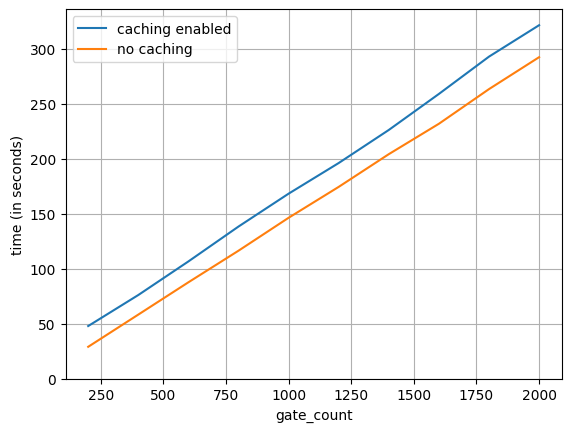

In [24]:
# Create a line chart with simulation time on y and gate count per circuit 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for gate_count in gate_counts:

    sel_durations_no_cache = [
        experiment["total_duration"]
        for experiment in vg_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["gate_count"] == gate_count
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["total_duration"]
        for experiment in vg_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["gate_count"] == gate_count
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))

ax = plt.subplot()
ax.plot(gate_counts, durations_with_cache)
ax.plot(gate_counts, durations_no_cache)
ax.set_xlabel("gate_count")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Total simulation time, averaged across seeds:")

plt.legend(["caching enabled", "no caching"])
plt.grid()
plt.show()


Net simulation time, averaged across seeds:


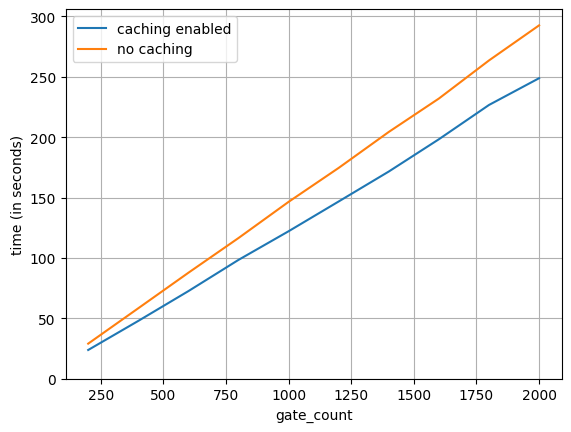

In [25]:
# Create a line chart with net simulation time on y and gate count per circuit 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for gate_count in gate_counts:

    sel_durations_no_cache = [
        experiment["simulate_without_cache"]["duration"]
        for experiment in vg_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["gate_count"] == gate_count
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["simulate_using_cache"]["duration"]
        for experiment in vg_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["gate_count"] == gate_count
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))

ax = plt.subplot()
ax.plot(gate_counts, durations_with_cache)
ax.plot(gate_counts, durations_no_cache)
ax.set_xlabel("gate_count")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)


printb("Net simulation time, averaged across seeds:")
plt.legend(["caching enabled", "no caching"])
plt.grid()
plt.show()


## RQ3.1: How does the amount of reordering steps influence simulation speed?

In [26]:
# Filter out and format experiment results with the reordering_varying_steps tag

rvs_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "reordering_varying_steps"]
print(f"Total amount of reordering_varying_steps experiments: {len(rvs_experiments)}")

Total amount of reordering_varying_steps experiments: 55


In [27]:
reordering_steps = [experiment["params"]["reordering_steps"] for experiment in rvs_experiments]
reordering_steps = list(set(reordering_steps))
reordering_steps.sort()

print("Reordering steps:", reordering_steps)

Reordering steps: [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]


Total simulation time, averaged across seeds:


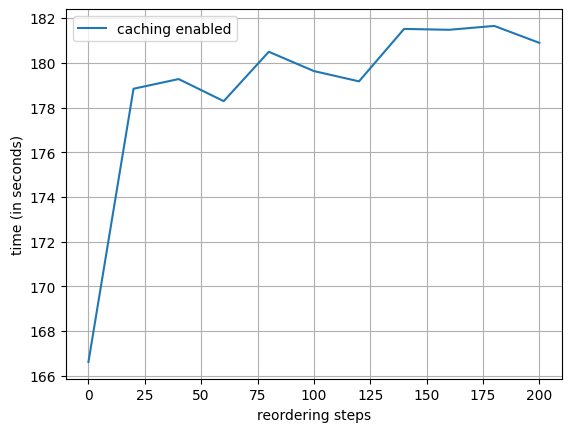

In [28]:
# Create a line chart with simulation time on y and reordering step count 
# on x. 

durations_with_cache = []

for reordering_step in reordering_steps:

    sel_durations_with_cache = [
        experiment["total_duration"]
        for experiment in rvs_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["reordering_steps"] == reordering_step
    ]
    
    durations_with_cache.append(mean(sel_durations_with_cache))

ax = plt.subplot()
ax.plot(reordering_steps, durations_with_cache)
ax.set_xlabel("reordering steps")
ax.set_ylabel("time (in seconds)")


printb("Total simulation time, averaged across seeds:")
plt.legend(["caching enabled"])
plt.grid()
plt.show()


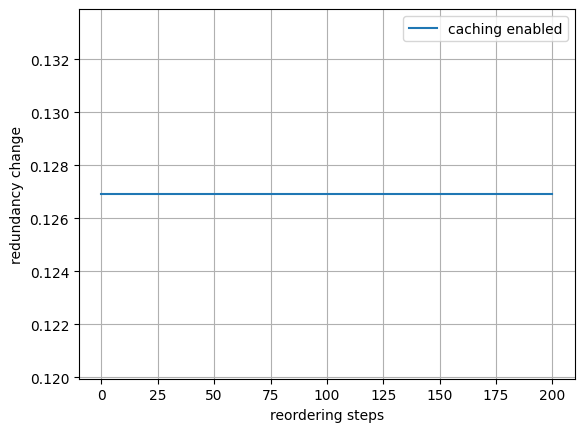

In [29]:
# Visualize change in redundnacy based on reordering steps

# TODO: Figure out why the same mean change is returned for all 
# reordering steps.

redundancy_changes = []

for reordering_step in reordering_steps:
    relevant_experiments = [
        experiment
        for experiment in rvs_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["reordering_steps"] == reordering_step
    ]

    relevant_redundancy_changes = [
        experiment["stats"]["redundancy_after_adjustment"] - experiment["stats"]["redundancy_before_adjustment"]
        for experiment in relevant_experiments
    ]

    redundancy_changes.append(mean(relevant_redundancy_changes))

ax = plt.subplot()
ax.plot(reordering_steps, redundancy_changes)
ax.set_xlabel("reordering steps")
ax.set_ylabel("redundancy change")

# ax.set_ylim([min(redundancy_changes), max(redundancy_changes)])

plt.legend(["caching enabled"])
plt.grid()
plt.show()

## RQ3.2: How does the amount of reordering steps influence the lengths and frequencies of the cached gate sequences across varying redundancy levels?

In [30]:
# Filter out and format experiment results with the reordering_varying_redundancy tag

rvr_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "reordering_varying_redundancy"]
print(f"Total amount of reordering_varying_redundancy experiments: {len(rvr_experiments)}")

Total amount of reordering_varying_redundancy experiments: 40


In [31]:
redundancies = [experiment["params"]["redundancy"] for experiment in rvr_experiments]
redundancies = list(set(redundancies))
redundancies.sort()

print("Redundancies:", redundancies)

Redundancies: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


In [32]:
# TBD: How to best visualize change in redundancy depending on starting redundancy


